In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import unique
from astropy.table import Column
from astropy.table import join
import celerite
import imp
mod = imp.load_source('modules.py', '../code/modules.py')
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



In [119]:
# Read  in the fit results for that particular light curve ...
outDir = '../dp2/Fig2_results_SDSS-PS1/'
resLcs =  os.listdir(outDir)

# Get the results for the real light curve ..
real = Table.read('190409_Celerite_real_Jeff1.txt', format='ascii')

def make_Fig2_plot(lcname, real) : 
    outDir = '../dp2/Fig2_results_SDSS-PS1/'
    results = np.load(outDir + lcname).item()

    t_exp = 8 * 365.0 # days 
    rho_in = results['rhoIN']
    tau_in = results['tauIN']
    t_exp = np.mean(tau_in / rho_in)
    rho_out = results['tauEXP'] / t_exp

    # Get the results for the real light curve ..
    m = real['lcname'] == lcname[:-4]+'.txt'


    # quick check : t_exp  should be identical as length of sdss-ps1 light curve 
    # stored in the data 
    if not  t_exp == real[m]['length_sdss-ps1']:
        print("np.mean(tau_in / rho_in) not equal to real[m]['length_sdss-ps1']")
        print('t_exp=',t_exp,' while the latter is',  
              real[m]['length_sdss-ps1'].data[0] )
        
    # the result of fitting real light curve
    # with identical cadence and errors ... 
    rho_out_real = real[m]['tauEXP_sdss-ps1'].data[0] / t_exp
    y_probe = np.log10(rho_out_real)
    # how wide around the result? 
    delta  = 0.1
    print('rho_out_real  is ', rho_out_real)
    print('log10(rho_out_real) is ', np.log10(rho_out_real))


    # plot Fig.2 equivalent for that cadence and errors ... 
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
    from scipy.stats import binned_statistic_2d
    print('Plotting Fig.2 for SDSS-PS1 segments of ', lcname )
    prior='Jeff1'   # Jeff1 is 1/sigma * 1/tau 

    # plotting space ... 
    #fig,ax = plt.subplots(1,1,figsize=(7.5,6), dpi=100)
    fig = plt.figure(figsize=(10,10), dpi=100)
    #[left,bottom,width, height]

    w = 0.4
    ax = fig.add_axes([0., 0.5, w, w])
    ax1 = fig.add_axes([0., 0., w, w])
    cax = fig.add_axes([w+0.05, 0.5, 0.02, w])
    x = np.log10(rho_in)
    y = np.log10(rho_out)

    stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                                 cmap=plt.cm.get_cmap('RdYlBu'))
    # labels...
    ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
    ax.set_ylabel(r'$\log_{10}(\rho_{out})$')

    plt.colorbar(image,cax,  label=r'$\log_{10}{(\mathrm{count})}$')
    # lines to guide the eye ...
    ax.grid()
    xlim = ax.get_xlim()
    x_line = np.arange(xlim[0], xlim[1],0.01)
    ax.plot(x_line,x_line, ls='-', lw=2, color='red', label='y=x')
    ax.axhline(-1, ls=':', lw=2, c='blue')
    ax.axvline(-1, ls='-', lw=2, c='blue')

    # calculate the median of log(rho_out)
    # Median of the log(y) is not the log(median(y)) .... 
    min_x, max_x , step_size = xlim[0],xlim[1], 0.1
    mean_x = np.arange(min_x, max_x+step_size , step_size)
    dx = 0.5 * step_size 
    median_y = np.zeros(len(mean_x))

    for j in range(len(median_y)):
        # take points that are within desired x_data limits for each bin
        # i.e. marginalize along y ( stack vertically)
        mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
        median_y[j] = np.median(y[mask])

    ax.plot(mean_x[:-1], median_y[:-1], c = 'magenta',lw=2, label='median')#, s=50 , edgecolor='black')
    ax.legend(fontsize=18)
    ax.set_title('SDSS-PS1 '+ lcname[:-4])
    ax.set_ylim(-3,1)
    ax.set_xlim(-3,1)
    ax.axhline(y_probe, ls='--', lw=3)
    ax.fill_between(x, y_probe-delta, y_probe+delta , alpha=0.3)

    m = ((y_probe-delta) < y) & (y < (y_probe+ delta))
    bins = np.linspace(-3,1,40)
    bin_cen = (bins[:-1] + bins[1:]) / 2
    #hist_i, bin_edges = np.histogram(x[m], bins, normed=True)
    #dbin = abs(bin_edges[1] - bin_edges[0])
    #fig,ax = plt.subplots(1,1,figsize=(7,7))
    ax1.hist(x[m], histtype='step', density=True, range=(-3,1))
    #ax.plot(bin_cen, hist_i , drawstyle='steps', label='')# color=color)
    #ax.plot(bin_cen, hist_i / (np.sum(hist_i)*dbin) , 
    #        drawstyle='steps', label='', color=color)
    ax1.set_xlabel(r'$\log_{10}(\rho_{in})$')
    ax1.set_ylabel('p'+r'$(\rho_{\mathrm{in}} | \rho_{\mathrm{out}})$')
    ax1.axvline(y_probe, ls='--', lw=3)
    #figname = lcname[:-4] +'_SDSS-PS1_'+prior+'_hist.png' 
    #plt.savefig(figname , bbox_inches='tight')
    #print('Saved as ', figname)


    figname = 'twopanel_'+lcname[:-4] +'_SDSS-PS1_'+prior+'.png'
    plt.savefig(figname, bbox_inches='tight')
    print('Saved as ', figname)

Available Fig.2 data for individual SDSS-PS1 light curves:
['1025069.npy', '3989384.npy', '1582753.npy', '1875034.npy', '1298222.npy', '991484.npy', '1638277.npy', '235286.npy', '3720533.npy', '596776.npy', '3037200.npy', '3997810.npy', '1058096.npy', '903870.npy', '448036.npy', '950569.npy', '3742361.npy', '284854.npy', '3232303.npy', '3759755.npy', '100520.npy', '1441903.npy', '908716.npy']
0 / 23
rho_out_real  is  0.1427048939352423
log10(rho_out_real) is  -0.8455611328935828
Plotting Fig.2 for SDSS-PS1 segments of  1025069.npy


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10


Saved as  twopanel_1025069_SDSS-PS1_Jeff1.png
1 / 23
rho_out_real  is  0.041319232685513206
log10(rho_out_real) is  -1.3838477520977628
Plotting Fig.2 for SDSS-PS1 segments of  3989384.npy
Saved as  twopanel_3989384_SDSS-PS1_Jeff1.png
2 / 23
np.mean(tau_in / rho_in) not equal to real[m]['length_sdss-ps1']
t_exp= 5226.9179369999965  while the latter is 5226.917936999998
rho_out_real  is  0.11528231247572047
log10(rho_out_real) is  -0.9382373204888956
Plotting Fig.2 for SDSS-PS1 segments of  1582753.npy
Saved as  twopanel_1582753_SDSS-PS1_Jeff1.png
3 / 23
rho_out_real  is  0.09123956863252088
log10(rho_out_real) is  -1.0398167766720081
Plotting Fig.2 for SDSS-PS1 segments of  1875034.npy
Saved as  twopanel_1875034_SDSS-PS1_Jeff1.png
4 / 23
rho_out_real  is  0.03357929240367262
log10(rho_out_real) is  -1.473928459729185
Plotting Fig.2 for SDSS-PS1 segments of  1298222.npy
Saved as  twopanel_1298222_SDSS-PS1_Jeff1.png
5 / 23
np.mean(tau_in / rho_in) not equal to real[m]['length_sdss-ps1']


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


Saved as  twopanel_100520_SDSS-PS1_Jeff1.png
21 / 23
rho_out_real  is  0.1302220868794516
log10(rho_out_real) is  -0.8853153491291309
Plotting Fig.2 for SDSS-PS1 segments of  1441903.npy
Saved as  twopanel_1441903_SDSS-PS1_Jeff1.png
22 / 23
rho_out_real  is  0.08936255071264802
log10(rho_out_real) is  -1.0488444434665503
Plotting Fig.2 for SDSS-PS1 segments of  908716.npy
Saved as  twopanel_908716_SDSS-PS1_Jeff1.png


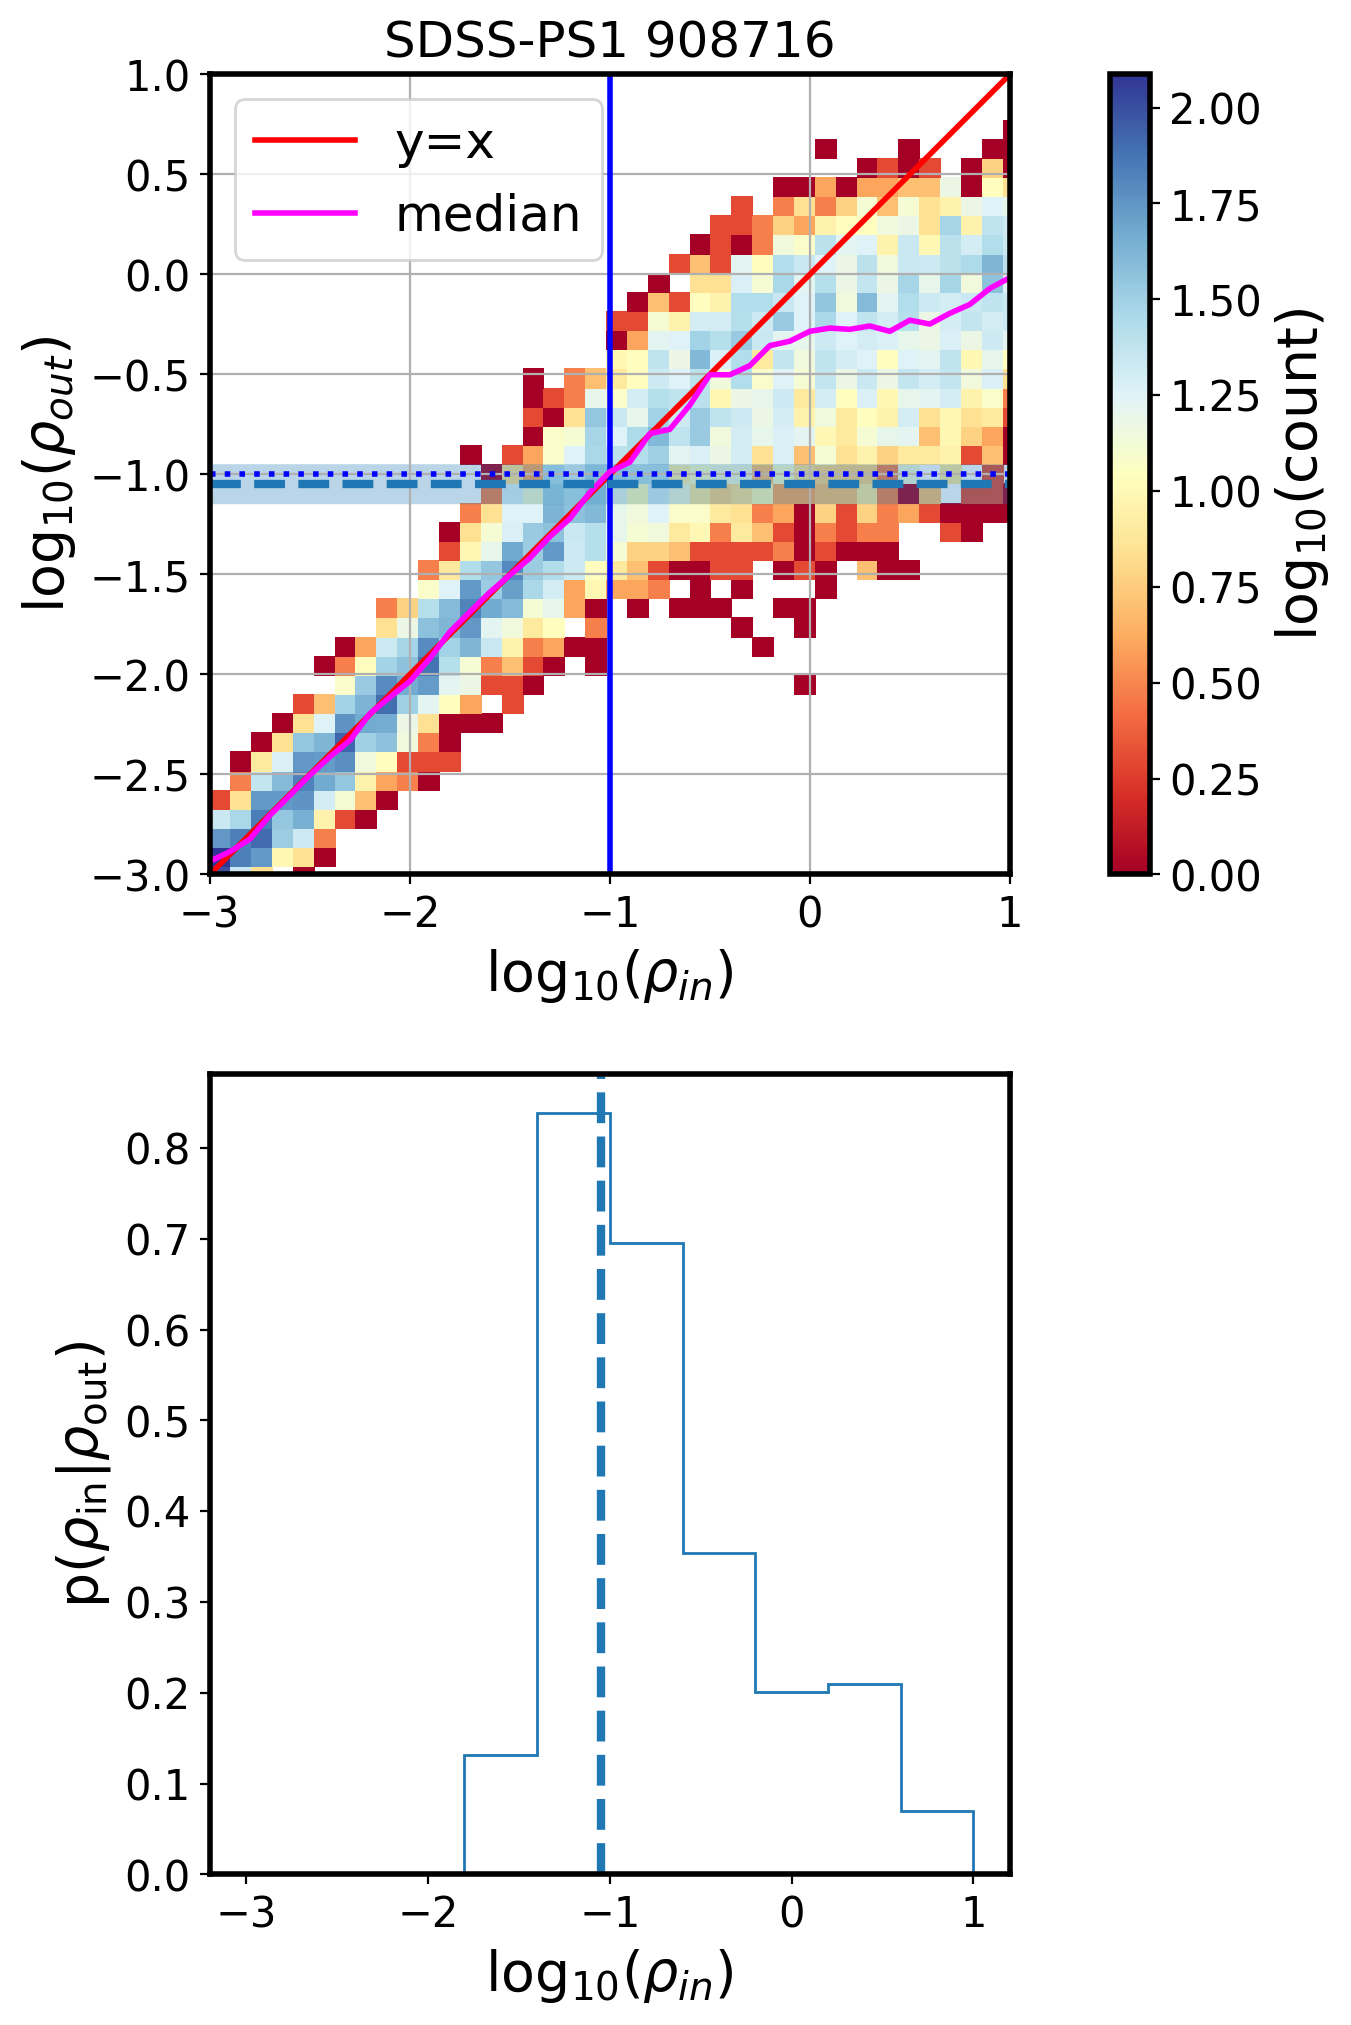

In [125]:
print('Available Fig.2 data for individual SDSS-PS1 light curves:' )
outDir = '../dp2/Fig2_results_SDSS-PS1/'
resLcs =  os.listdir(outDir)
print(resLcs)

for i in range(len(resLcs)):
    print(i,'/',len(resLcs))
    make_Fig2_plot(resLcs[i], real)
    

For that light curve,  take the horizontal slice around the result of fit when using the real data at that cadence and errors... The horizontal dashed line marks the result ,  and we're plotting the histogram of $\rho_{in}$ that could produce such $\rho_{out}$